In [105]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import tqdm

myseed = 12345
torch.manual_seed(myseed)
torch.random.manual_seed(myseed)
random.seed(0)
np.random.seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(myseed)
torch.autograd.set_detect_anomaly(True)  # 可在NaN 出现时报错，定位错误代码。正向传播时：开启自动求导的异常侦测
# 反向传播时：在求导时开启侦测
#with torch.autograd.detect_anomaly():
#    loss.backward()
torch.multiprocessing.set_sharing_strategy('file_system')

In [106]:
# 使用 GPU
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [107]:
# 数据预处理, 调整图片大小
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize([96, 96])])

# 下载Fashion-MNIST训练集数据，并构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序
trainset = torchvision.datasets.FashionMNIST('dataset/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 下载Fashion-MNIST测试集数据，并构建测试集数据载入器trainloader,每次从测试集中载入64张图片，每次载入都打乱顺序
testset = torchvision.datasets.FashionMNIST('dataset/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [108]:
class inception(torch.nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs) -> None:
        super(inception, self).__init__(**kwargs)
        self.r1 = torch.nn.Conv2d(in_channels, c1, kernel_size=1)
        self.r2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, c2[0], kernel_size=1), torch.nn.ReLU(),
                                      torch.nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        )
        self.r3 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, c3[0], kernel_size=1), torch.nn.ReLU(),
                                      torch.nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
                                      )
        self.r4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                      torch.nn.Conv2d(in_channels, c4, kernel_size=1)
        )
        
    def forward(self, x):
        p1 = torch.nn.functional.relu(self.r1(x))
        p2 = torch.nn.functional.relu(self.r2(x))
        p3 = torch.nn.functional.relu(self.r3(x))
        p4 = torch.nn.functional.relu(self.r4(x))
        x = torch.cat((p1, p2, p3, p4), dim=1)
        return x

In [109]:
class GoogleNet(torch.nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), torch.nn.ReLU(),
                                           torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(64, 64, kernel_size=1), torch.nn.ReLU(),
                                          torch.nn.Conv2d(64, 192, kernel_size=3, padding=1), torch.nn.ReLU(),
                                          torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer3 = torch.nn.Sequential(inception(192, 64, (96, 128), (16, 32), 32), torch.nn.ReLU(), 
                                          inception(256, 128, (128, 192), (32, 96), 64), torch.nn.ReLU(),
                                          torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.layer4 = torch.nn.Sequential(inception(480, 192, (96, 208), (16, 48), 64), torch.nn.ReLU(), 
                                          inception(512, 160, (112, 224), (24, 64), 64), torch.nn.ReLU(),
                                          inception(512, 128, (128, 256), (24, 64), 64), torch.nn.ReLU(),
                                          inception(512, 112, (144, 288), (32, 64), 64), torch.nn.ReLU(),
                                          inception(528, 256, (160, 320), (32, 128), 128), torch.nn.ReLU(),
                                          torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.layer5 = torch.nn.Sequential(inception(832, 256, (160, 320), (32, 128), 128), torch.nn.ReLU(), 
                                          inception(832, 384, (192, 384), (48, 128), 128), torch.nn.ReLU())
        self.layer6 = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d((1, 1)), torch.nn.Flatten(),
                                          torch.nn.Linear(1024, 10))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

In [110]:
model = GoogleNet()
model = model.to(device=try_gpu())

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

model.train()
epochs= 5

Loss_data = {
    "train": [],
    "dev": []
}

for epoch in tqdm.tqdm(range(epochs)):
    Loss = 0
    for batch_x, batch_y in trainloader:
        batch_x, batch_y = batch_x.to(device=try_gpu()), batch_y.to(device=try_gpu())
        prediction = model(batch_x)
        loss = criterion(prediction, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        Loss_data["train"].append(float(loss))
        Loss_data["dev"].append(0)

100%|██████████| 5/5 [18:25<00:00, 221.00s/it]


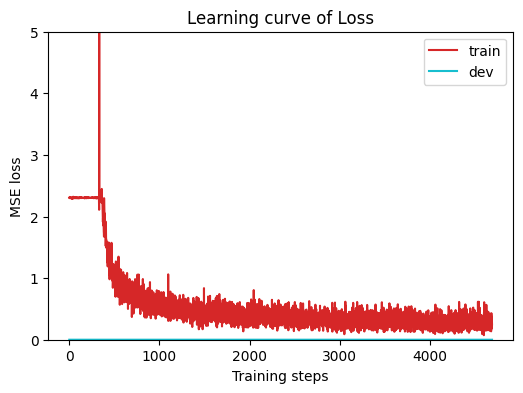

In [111]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

plot_learning_curve(Loss_data, "Loss")

In [116]:
model.eval()
predicted_labels = []
epoch = 1
accuracy_sum = 0
with torch.no_grad():
    for batch_x, batch_y in testloader:
        batch_x, batch_y = batch_x.to(device = try_gpu()), batch_y.to(device = try_gpu())
        prediction = model(batch_x)
        predicted_label = torch.argmax(prediction,1)
        accuracy = torch.eq(batch_y, predicted_label).float().mean()
        accuracy_sum = accuracy_sum + accuracy
        epoch = epoch + 1

print("准确率: %f" % (accuracy_sum / epoch))

准确率: 0.889043
